In [1]:
import pandas as pd
import numpy as np
from numpy import fliplr
from numpy import flipud
from numpy import array
from pandas.io.json import json_normalize
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import json
import math
import pymongo
from pymongo import MongoClient

def connect_database():
 
    client = MongoClient('localhost', 27017)
    db = client['bitcoin']
    collection = db['final_data']
    return db, collection

def data_extraction(filed, collection):
    '''
    extract a certain filed('close') of data from the collecttion 
    '''

    data = []
    for doc in list(collection.find()):
        data.append(doc[filed])
    data = array(data)
    data = flipud(data)
    if filed == 'close':
        difference = np.zeros(len(data)-1)
        for i in range(1, len(data)):
            difference[i-1] = data[i] - data[i-1]
        return difference
    return data


def price_extraction(filed, collection):
    data = []
    for doc in list(collection.find()):
        data.append(doc[filed])
    data = array(data)
    data = flipud(data)
    difference = np.zeros(len(data)-1)
    for i in range(1, len(data)):
        difference[i-1] = data[i] - data[i-1]
    return difference

def feature_engineering(df):
    """
    preprocess data for better result
    :return:
    """
def take_by_window(dataset, stm, window):
    x, y = [], []
    for i in range(len(dataset) - window ):
        tmp = []
        tmp = np.append(dataset[i:(i + window)], stm[i+window])
        
        x.append(list(tmp))
        y.append(dataset[i + window,])
    x = np.array(x)
    print(x.shape)
    y = np.array(y)
    print(x.shape[0],x.shape[1])
    x = np.reshape(x, (x.shape[0] ,1 , x.shape[1]))
    print(x.shape)
    return x, y

def pred_model(stm, x_train, y_train, step_size=1, num_features=50, epochs=100, batch_size=128, verbose=2, pred_num=300):
    """
    ML model: LSTM
    Look_back: how many point
    :return:
    """

    model = Sequential()
    model.add(LSTM(4, input_shape=(step_size, num_features)))
    model.add(Dense(1))  # output file size
    model.add(Activation('tanh'))  # active function
    model.add(Dropout(0.2))  # drop out regulation
    model.compile(loss='mse', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    
    
    pred_feature = x_train[-1]
    print(pred_feature.shape)
    print(type(pred_feature))
    pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))
    print(pred_feature.shape)
    x_test = list([x_train[-1]])
    #pred_num = 1000
    y_test = []
    x_test = []
    
    for i in range(pred_num):
        pred_data = model.predict(pred_feature)
        print(pred_data)
        y_test.append(pred_data)
        pred_feature = np.append(pred_feature[0,0,1:-1], pred_data)
        pred_feature = np.append(pred_feature, stm)
        pred_feature = np.reshape(pred_feature, (1 ,1 , num_features))
    pred_train = model.predict(x_train)
    
    #score = model.evaluate(array(x_test[0:-1]), y_test, batch_size=128)

    return pred_train , np.reshape(array(y_test), (pred_num))



Using TensorFlow backend.


In [2]:
'''connect to DB: bitcoin and collection: btc'''
db, collection = connect_database()
df = data_extraction('close', collection)
time = data_extraction('_id', collection)
stm = data_extraction('mean', collection)
dataset = df.astype('float32')
time = time.astype('int32')
mms = MinMaxScaler(feature_range=(0, 1))

'''construct a scale based on dataset'''
dataset = mms.fit_transform(dataset)

'''define the size of lookback'''
window = 400

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [3]:
'''divide dataset to training set and testing set'''
train_size = int(len(dataset)*0.994)
test_size = len(dataset)-train_size
train_set, test_set = dataset[0:train_size], dataset[train_size:]
train_stm = stm[0: train_size]
print(len(train_set),len(test_set),len(dataset))

10843 66 10909


In [4]:
'''prepare the training data'''
x_train, y_train = take_by_window(train_set, train_stm, window)
y_test = test_set

(10443, 401)
10443 401
(10443, 1, 401)


In [5]:
'''get the predict data'''
pred_train, pred_test = pred_model(train_stm[-1], x_train, y_train, step_size=1, num_features = window+1, epochs=100, batch_size=128, verbose=2, pred_num = test_size)
#print(score)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/100
1s - loss: 0.0371
Epoch 2/100
0s - loss: 0.0311
Epoch 3/100
0s - loss: 0.0313
Epoch 4/100
0s - loss: 0.0327
Epoch 5/100
0s - loss: 0.0306
Epoch 6/100
0s - loss: 0.0309
Epoch 7/100
0s - loss: 0.0312
Epoch 8/100
0s - loss: 0.0308
Epoch 9/100
0s - loss: 0.0325
Epoch 10/100
0s - loss: 0.0312
Epoch 11/100
0s - loss: 0.0307
Epoch 12/100
0s - loss: 0.0303
Epoch 13/100
0s - loss: 0.0317
Epoch 14/100
0s - loss: 0.0319
Epoch 15/100
0s - loss: 0.0319
Epoch 16/100
0s - loss: 0.0310
Epoch 17/100
0s - loss: 0.0321
Epoch 18/100
0s - loss: 0.0318
Epoch 19/100
0s - loss: 0.0313
Epoch 20/100
0s - loss: 0.0304
Epoch 21/100
0s - loss: 0.0321
Epoch 22/100
0s - loss: 0.0316
Epoch 23/100
0s - loss: 0.0304
Epoch 24/100
0s - loss: 0.0311
Epoch 25/100
0s - loss: 0.0315
Epoch 26/100
0s - loss: 0.0321
Epoch 27/100
0s - loss: 0.0301
Epoch 28/100
0s - loss: 0.

In [6]:
'''inverse the scale'''
pred_train = mms.inverse_transform(pred_train)
y_train = mms.inverse_transform(y_train)
pred_test = mms.inverse_transform(pred_test)
y_test = mms.inverse_transform(y_test)

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

In [7]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[window:len(pred_train) + window] = pred_train[:,0] 

In [8]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(pred_train) + window:] = pred_test

In [9]:
print(len(pred_test))

66


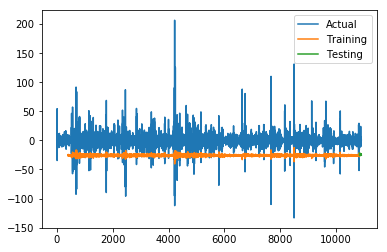

In [10]:
plt.plot(df, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [11]:
tPredictPlot = np.empty_like(dataset)
tPredictPlot[:] = np.nan
tPredictPlot[len(pred_train) + window:] = df[-test_size:]

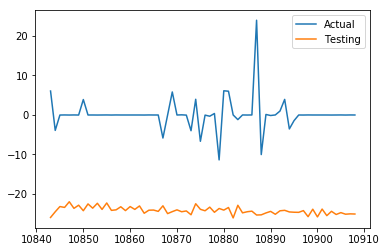

In [12]:
plt.plot(pd.DataFrame(tPredictPlot, columns=["close"]).close, label='Actual')
#plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [13]:
trainScore = math.sqrt(mean_squared_error(y_train, pred_train[:, 0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, pred_test[:]))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 27.28 MSE
Test Score: 24.76 MSE


In [14]:
'''count the accuracy rate of prediction based on the price up and down'''
correct = []
for i in range(len(pred_test)):
    if (y_test[i]>0 and pred_test[i]>0) or (y_test[i]==0 and pred_test[i]==0) or (y_test[i]<0 and pred_test[i]<0):
        correct.append(1)

            
accuracy_rate = sum(correct)/len(pred_test)

In [15]:
'''save the prediction and time'''

coll_test = db['test1']

for i in range(len(pred_test)):
    db.test1.insert_one({'pred_test': float(pred_test[i]), 
                        'time': int(time[len(train_set)] + i*60)
                        })

In [16]:
accuracy_rate

0.36363636363636365